<a href="https://colab.research.google.com/github/CapClark/MNIST-Rotated-Digits-Augmented-Classifications-/blob/main/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification using CNNs


In [65]:
# Import torch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# import matplotlib
import matplotlib.pyplot as plt

# Check version
torch.__version__
torchvision.__version__

'0.18.0+cu121'

In [66]:
# Set up training data
from torchvision import datasets
train_data = datasets.MNIST(
    root="data", # where to download data to?
    train=True, # do we want training datasets of MNIST?
    download=True, # do we want to download?
    transform=torchvision.transforms.ToTensor(), # how do we want to transform the data?
    target_transform=None # how do we want to transform the labels/target?
)
# NOTE: Each element typically consists of a tuple '(image, label)' where 'image' is a tensor representing a single image from the dataset and label is the corresponding label to that image
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [67]:
len(train_data), len(test_data)

(60000, 10000)

In [110]:
# See the first training example
image, label = train_data[0]

label

5

In [111]:
class_names = train_data.classes # provides access to the class labels or names associated with the dataset
# Returns a dictionary of labels to its corresponding word
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [70]:
# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: 5 - five


## Data Visualization

Image shape


Text(0.5, 1.0, '5')

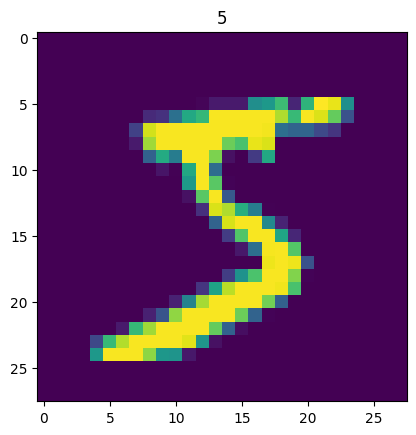

In [71]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape")
plt.imshow(image.squeeze())
plt.title(label)

(-0.5, 27.5, 27.5, -0.5)

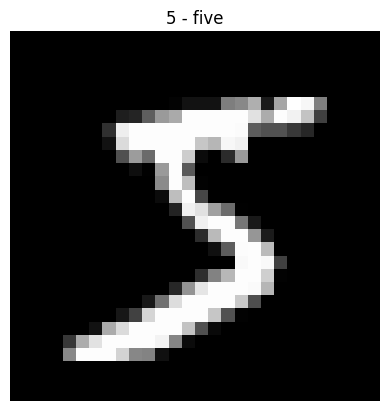

In [72]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

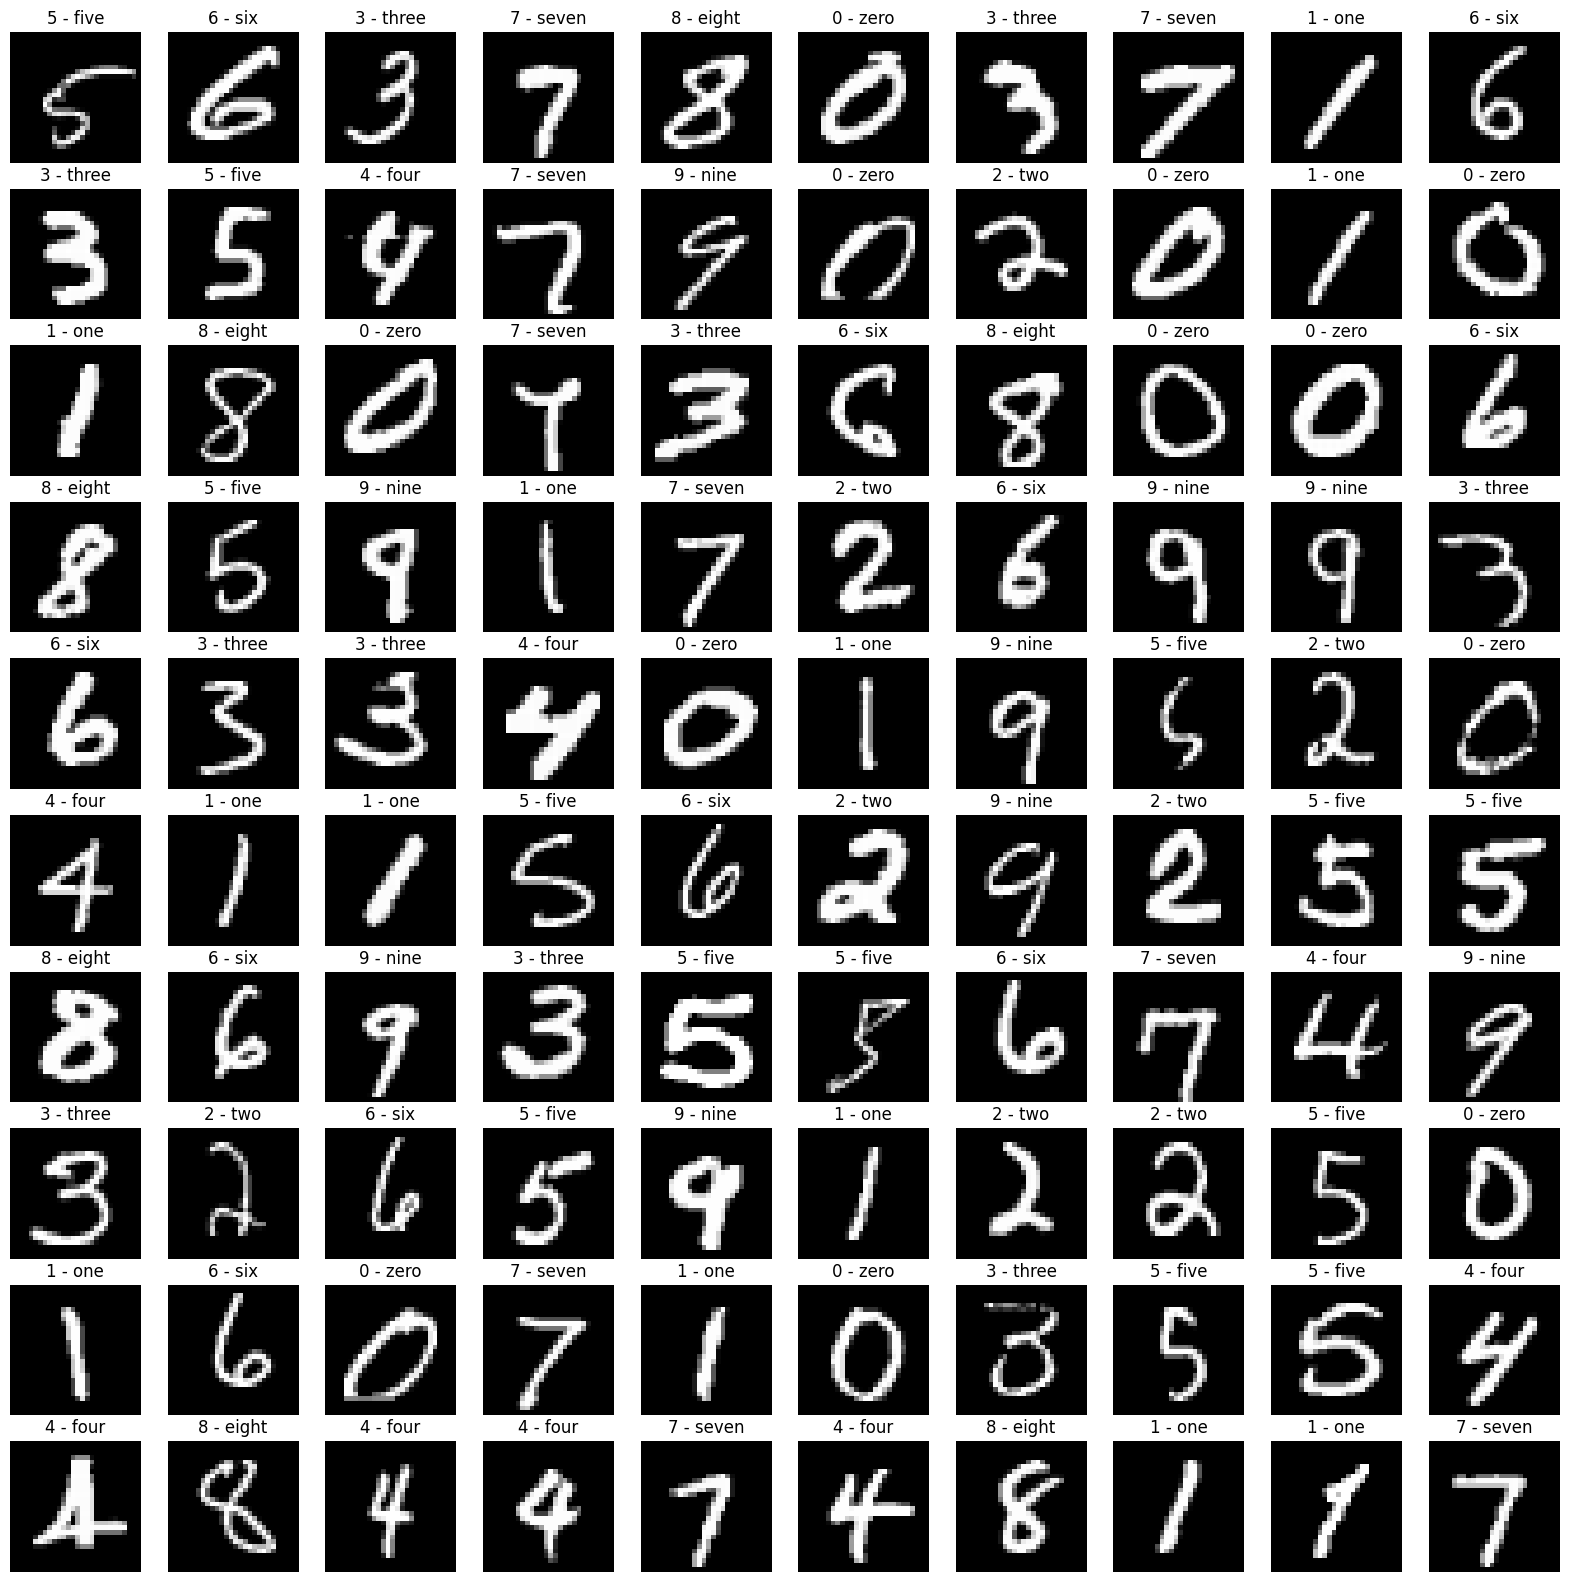

In [112]:
# Plot more imags
fig = plt.figure(figsize=(20,20)) # Creates a new figure, which acts as (figsize is width and height in inches)
rows, cols = 10,10
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item() # randint is used to generate a specific number between a range of numbers; .item() converts it into a single integer
  img, label = train_data[random_idx]
  fig.add_subplot(rows,cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [74]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## Prepare DataLoader

DataLoader turns our dataset into Python iterable (i.e. we want to turn it into mini-batches)

In [75]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameters
BATCH_SIZE = 32

# Turn data sets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78eec80d5cf0>,
 <torch.utils.data.dataloader.DataLoader at 0x78eec80d7070>)

In [76]:
# Let's check what we've created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Legnth of train_dataloder: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Legnth of test_dataloder: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x78eec80d5cf0>, <torch.utils.data.dataloader.DataLoader object at 0x78eec80d7070>)
Legnth of train_dataloder: 1875 batches of 32
Legnth of test_dataloder: 313 batches of 32


In [113]:
# Check out what's inside the training dataloder
train_features_batch, train_labels_batch = next(iter(train_dataloader)) # extracts a single batch of features (images) and labels from the training dataloder
""" iter(train_dataloader) creates an iterator from the dataloder.
    - an iterator is an object that enables traversing through all the elements in the dataloder one by one
    next(iter(train-dataloader))
    - retrieves the next batch from the iterator. In this case, it gets the first batch of data when called forthe first time.
"""
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 9, label size: torch.Size([])


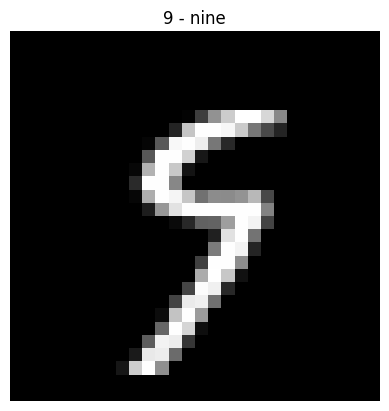

In [78]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [79]:
class_names = train_data.classes # yields the list of class names associate with the data
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## 3. Model Building

In [80]:
class MNISTModel(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int = 10,
               output_shape: int = 10):
    super().__init__()
    self.convBlock1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.convBlock2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride=1),
        nn.Sigmoid(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=output_shape,
                  kernel_size=2,
                  padding=1),
        nn.Sigmoid(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.convBlock3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride=1),
        nn.Sigmoid(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=output_shape,
                  kernel_size=2,
                  padding=1),
        nn.Sigmoid(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )
    self.convBlock4 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=2,
                  padding=1,
                  stride=1),
        nn.Sigmoid(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=output_shape,
                  kernel_size=2,
                  padding=1),
        nn.Sigmoid(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
  def forward(self, x):

    x = self.convBlock2(self.convBlock1(x))
    x = x.view(-1, 490)
    x = self.classifier(x)
    return x


torch.manual_seed(42)
model = MNISTModel(input_shape=1,
                   hidden_units=10,
                   output_shape=len(class_names))

model

MNISTModel(
  (convBlock1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convBlock2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): Sigmoid()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convBlock3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
    (2): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): Sigmoid()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=490, out_features=10, bias=True)
  )
  (convBlock4): Sequen

In [81]:
# Creating a dummy data
dummy_image = torch.randn(1,28,28)

model(dummy_image)

tensor([[ 0.0843, -0.4607,  0.2449, -0.5109,  0.5821,  0.4708, -0.0041, -0.1210,
          0.2994,  0.0607]], grad_fn=<AddmmBackward0>)

## Setting up loss function, evaluation metrics and optimizer

In [82]:
def accuracy_fn(y_true, y_pred):
    """
    Calculates accuracy between predicted and true labels.

    Args:
        y_true (torch.Tensor): True labels, shape [batch_size]
        y_pred (torch.Tensor): Predicted labels or logits, shape [batch_size, num_classes]

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g., 78.45
    """
    # If y_pred contains raw logits, get the predicted class by taking the argmax
    y_pred_classes = torch.argmax(y_pred, dim=1)

    # Ensure y_true is the same device as y_pred_classes
    y_true = y_true.to(y_pred_classes.device)

    correct = torch.eq(y_true, y_pred_classes).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [83]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

## Creating a function for training and evaluation/testing loops

### Train Loop Function

In [84]:
def train_loop(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = "cpu"):
  """ Uses dataloder to perform training (Recall: dataloader 'batchifies' our data)"""
  train_loss, train_acc = 0, 0
  model.train()

  N = len(train_dataloader)
  # Loopy loop through training batches
  for batch, (X, y) in enumerate(data_loader): # features are X's, outputs are y's

    y_preds = model.forward(X) # forward prop
    loss = loss_fn(y_preds, y) # loss calc

    train_loss += loss
    train_acc += accuracy_fn(y, y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Find average loss of batch by dividing the sum by length of dataloader
  train_loss = train_loss / N
  train_acc = train_acc / N

  # Output such values
  print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} ")





### Test Loop Functon

In [85]:
def test_loop(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = "cpu"):

  """ Performs testing loops step on model going over data_loader """

  test_loss, test_acc, N = 0.0, 0.0, len(data_loader)

  # Since we're just prediction, we put the model in evaluation mode (saves time)
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()
      test_acc += accuracy_fn(y, test_pred)

  test_loss = test_loss / N
  test_acc = test_acc / N

  print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:4f} ")

## Training and Testing Model

In [86]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Meaure time
from timeit import default_timer as timer
from tqdm.auto import tqdm

def print_train_time(start:float,
                     end:float,
                     device: torch.device=None):
  """ Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on cpu: {total_time:.3f} seconds")
  return total_time

# Model Training
EPOCHS = 3

trainTimeStart = timer() # starts timer
for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch number: {epoch}\n-------")
  train_loop(model=model,
             data_loader=train_dataloader,
             optimizer=optimizer,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn)
  test_loop(model=model, # test loop no need optimizer
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn)

  trainTimeEnd = timer() # stops timer
  TotalTrainTime = print_train_time(start=trainTimeStart,
                                    end=trainTimeEnd)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch number: 0
-------
Train Loss: 1.3480 | Train Accuracy: 53.0750 
Test Loss: 0.4176 | Test Accuracy: 87.945000 
Train time on cpu: 65.008 seconds
Epoch number: 1
-------
Train Loss: 0.3276 | Train Accuracy: 90.2183 
Test Loss: 0.2503 | Test Accuracy: 92.570000 
Train time on cpu: 129.902 seconds
Epoch number: 2
-------
Train Loss: 0.2198 | Train Accuracy: 93.4817 
Test Loss: 0.1819 | Test Accuracy: 94.688333 
Train time on cpu: 196.895 seconds


## Model Evaluation

In [103]:
def eval_model(model, data_loader, loss_fn, accuracy_fn, device):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    model.eval()
    loss, acc = 0.0, 0.0
    with torch.no_grad():  # Disable gradient calculation
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            # Make predictions
            y_pred = model(X)

            # Calculate loss and accumulate
            loss += loss_fn(y_pred, y).item()

            # Calculate accuracy and accumulate
            acc += accuracy_fn(y_true=y, y_pred=y_pred)

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

    return {
        f"model_acc: {acc:.2f}%",
        f"model_loss: {loss:.2f}",
        f"model_name: {model.__class__.__name__}"
    }


In [104]:
# Calculate model 0 results on test dataset
model_results = eval_model(model=model,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device="cpu")

model_results

{'model_acc: 95.02%', 'model_loss: 0.17', 'model_name: MNISTModel'}

In [89]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = "cpu"):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0) # Prep the sample
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # Get prediction probability (pass raw inputs to softmax function)
      pred_probs.append(pred_prob)

    return torch.stack(pred_probs) # stack turns pred_probs from a list to a tensor

In [90]:
import random

# Ensure test_data is a sequence and inspect its type and elements
print(f"type(test_data): {type(test_data)}")

# Assuming test_data should be a list of tuples
try:
    test_data_list = list(test_data)
    print(f"First element: {test_data_list[0]}")
except TypeError as e:
    print(f"Conversion to list failed: {e}")

# Ensure the elements are tuples
if all(isinstance(item, tuple) and len(item) == 2 for item in test_data_list):
    test_samples = []
    test_labels = []

    # Randomly sample 9 elements from test_data_list
    sampled_data = random.sample(test_data_list, k=9)

    for sample, label in sampled_data:
        test_samples.append(sample)
        test_labels.append(label)

    # View the first sample shape
    print(test_samples[0].shape)
else:
    print("test_data_list does not contain tuples or the tuples do not have exactly 2 elements.")


type(test_data): <class 'torchvision.datasets.mnist.MNIST'>
First element: (tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

In [91]:
import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, '9 - nine')

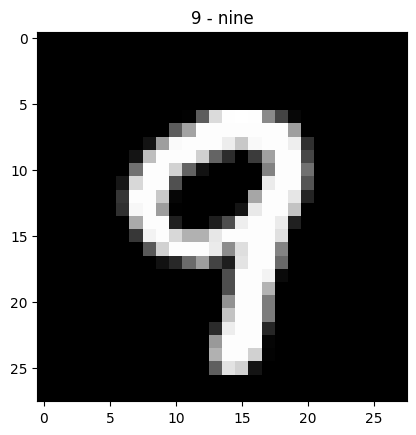

In [92]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [93]:
# Making predictions
prediction_probability = make_predictions(model=model,
                                          data=test_samples)

prediction_probability[:2]

tensor([[3.6130e-06, 2.3317e-07, 7.3733e-06, 1.2116e-04, 1.1717e-02, 2.2205e-05,
         2.3881e-07, 1.2551e-02, 1.2708e-03, 9.7431e-01],
        [9.9956e-01, 1.0897e-09, 8.2438e-05, 9.7418e-06, 3.7619e-08, 1.7293e-04,
         1.3719e-04, 3.0578e-06, 3.0564e-05, 4.2013e-06]])

In [94]:
# Convert prediction probability to labels
prediction_classes = prediction_probability.argmax(dim=1)
prediction_classes

tensor([9, 0, 9, 2, 6, 1, 8, 5, 1])

<ipython-input-95-195a5e0301f3>:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


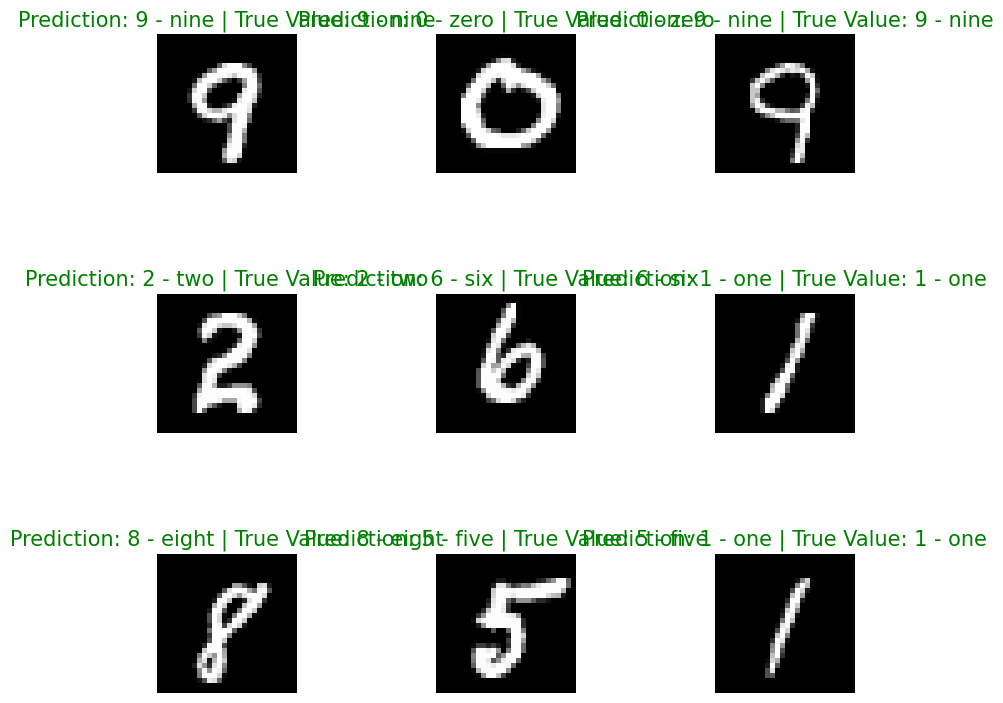

In [95]:
# Plotting the predictions given
torch.manual_seed(42)
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples): # 'enumerate' generates pairs of (index, value) for each item in the list or tuple
  ax = plt.subplot(nrows, ncols, i+1) # Creating subplot
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[prediction_classes[i]]
  true_label = class_names[test_labels[i]] # Getting the true value of the picture
  title_text = f"Prediction: {pred_label} | True Value: {true_label}"

  # Check for equality between the prediction and true values
  if pred_label == true_label:
    ax.set_title(title_text, fontsize=15, c="g")
  else:
    ax.set_title(title_text, fontsize=15, c="r")

  plt.axis(False)
      # Adjust every odd column to be slightly shifted up
  if (i % ncols) % 2 == 1:  # Check if it is an odd column
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 + 10, pos.width, pos.height])  # Shift up by 0.05

# Adjust layout to fit titles and subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(hspace=0.5, wspace=0.5) # Increase vertical space between rows
plt.subplots_adjust(wspace=1)

